In [1]:

# best model choice:    --> InceptionResNetV2
#                          (--> "recognition_vehicle_03-models.ipynb")


In [2]:

# import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# execute if warnings should be ignored
import warnings
warnings.filterwarnings('ignore')


In [3]:

# create a list with the imagepaths for training and testing
#       from windows:  C:\Users\dietm\Documents\Data Science_Didi\Projekt\Projekt Recognition\data_vehicle_recognition\vehicles
dloadpath = Path('./data_vehicle_recognition/')
imagepaths = list(dloadpath.rglob('**/*.jpg'))


In [4]:
len(imagepaths)

522

In [5]:

imagepaths[138]


WindowsPath('data_vehicle_recognition/vehicles/bus/images (19).jpg')

In [6]:

# create a list with labels of the images:
labels = [str(imagepaths[i]).split("\\")[-2] for i in range(len(imagepaths))]


In [7]:
labels[138]

'bus'

In [8]:

# create a DataFrame with the filepath (as string) and the labels of the images

paths = pd.Series(imagepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate paths and labels
df = pd.concat([paths, labels], axis=1)

# shuffle the DataFrame and reset index and remove the old one:
df01 = df.sample(frac=1,random_state=42).reset_index(drop=True)


In [9]:

df01.head()


,Filepath,Label
0,data_vehicle_recognition\vehicles\scooty\image...,scooty
1,data_vehicle_recognition\vehicles\scooty\image...,scooty
2,data_vehicle_recognition\vehicles\bike\2Q__ (6...,bike
3,data_vehicle_recognition\vehicles\car\images (...,car
4,data_vehicle_recognition\vehicles\boat\images ...,boat


In [10]:

# 9 different labels and their titles:
df01.Label.unique()


array(['scooty', 'bike', 'car', 'boat', 'helicopter', 'truck', 'bus',
       'plane', 'cycle'], dtype=object)

In [11]:
type(df01["Filepath"])

pandas.core.series.Series

In [12]:

# total number of images:
df01.shape[0]


522

In [13]:

# total number of images each category:
df01.Label.value_counts()


Label
car           65
cycle         65
scooty        63
helicopter    57
bike          55
boat          55
truck         55
bus           55
plane         52
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

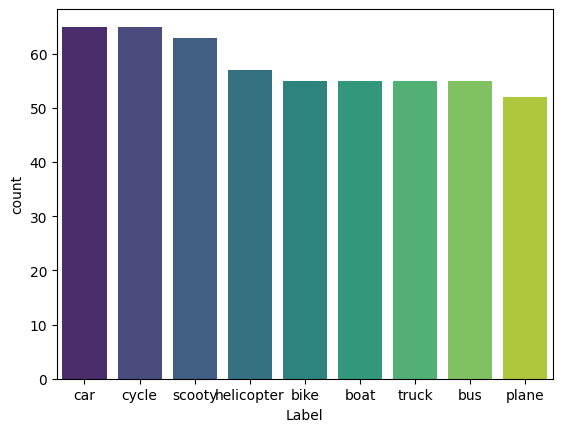

In [14]:

# number of images each category visualized: --> different numbers
sns.countplot(data=df01,x="Label",palette="viridis",order=df01.Label.value_counts().index)


In [15]:

# for a better train_data_set --> all categories with same size: 52
list_indizes = []

for i in df01.Label.unique():
    if len(df01[df01.Label==f'{i}']) > 52:
        [list_indizes.append(i) for i in df01[df01.Label == f'{i}'].iloc[:(len(df01[df01.Label==f'{i}']) - 52),:].index]        


In [24]:
len(list_indizes)

54

In [25]:

# delete the rows of the data set:
df01.drop(index=list_indizes,inplace=True)


In [26]:
df01.Label.value_counts()

Label
truck         52
bus           52
plane         52
bike          52
boat          52
helicopter    52
car           52
scooty        52
cycle         52
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

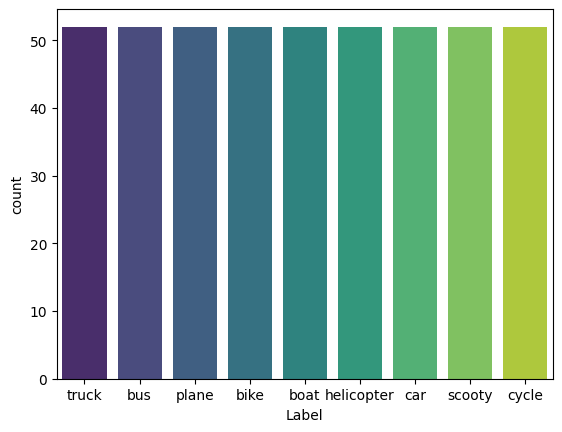

In [27]:
sns.countplot(data=df01,x="Label",palette="viridis",order=df01.Label.value_counts().index)

In [28]:

# create new indices for the data set and remove the old one:
df01.reset_index(drop=True,inplace=True)


In [29]:

# shape data set: 522 --> 468 rows with 2 features:
df01


,Filepath,Label
0,data_vehicle_recognition\vehicles\truck\2Q__.jpg,truck
1,data_vehicle_recognition\vehicles\bus\Z (12).jpg,bus
2,data_vehicle_recognition\vehicles\plane\9k_ (6...,plane
3,data_vehicle_recognition\vehicles\bus\images (...,bus
4,data_vehicle_recognition\vehicles\truck\images...,truck
...,...,...
463,data_vehicle_recognition\vehicles\boat\9k_ (5)...,boat
464,data_vehicle_recognition\vehicles\boat\Z (6).jpg,boat
465,data_vehicle_recognition\vehicles\cycle\images...,cycle
466,data_vehicle_recognition\vehicles\scooty\image...,scooty


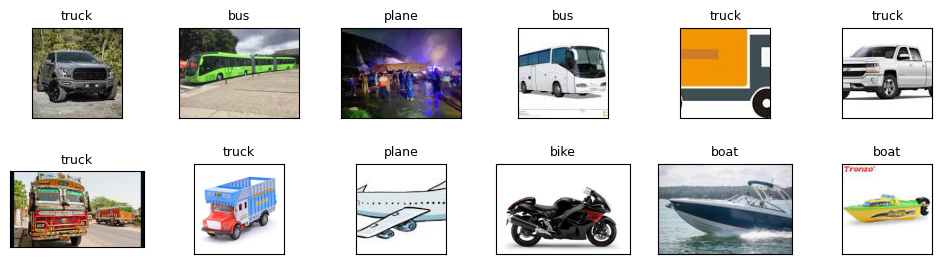

In [30]:

# visualization of images with subplots without scalenumbers:
fig, axes = plt.subplots(nrows=2,ncols=6,subplot_kw={'xticks':[],'yticks':[]},figsize=(10,3))

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df01.Filepath[i]))
    ax.set_title(df01.Label[i],fontsize=9)

plt.tight_layout(pad=2)
plt.show()


In [31]:

# import library for image recognition:
import tensorflow as tf


In [32]:

from sklearn.model_selection import train_test_split


In [33]:

# train/test split
# use only a small part of the data set in the case of being very big
# --> "df01.sample(frac=0.1)"
train_df,test_df = train_test_split(df01, test_size=0.2,random_state=42)


In [34]:

# load the images with a generator and Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)


In [35]:

train_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',
                                                   target_size=(224, 224),class_mode='categorical',
                                                   batch_size=32,seed=0,subset='training',rotation_range=30,
                                                   zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                                                   shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

val_images = train_generator.flow_from_dataframe(dataframe=train_df,x_col='Filepath',y_col='Label',
                                                 target_size=(224, 224),class_mode='categorical',batch_size=32,
                                                 seed=0,subset='validation',rotation_range=30,zoom_range=0.15,
                                                 width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,
                                                 horizontal_flip=True,fill_mode="nearest")

test_images = test_generator.flow_from_dataframe(dataframe=test_df,x_col='Filepath',y_col='Label',
                                                 target_size=(224, 224),class_mode='categorical',batch_size=32,
                                                 shuffle=False)


Found 300 validated image filenames belonging to 9 classes.
Found 74 validated image filenames belonging to 9 classes.
Found 94 validated image filenames belonging to 9 classes.


In [36]:

# initializing the best keras_model of my test:
# --> "recognition_vehicle_03-models.ipynb"
model = tf.keras.applications.InceptionResNetV2


In [37]:

# Loading the pretrained model:
kwargs = {'input_shape':(224, 224, 3),'include_top':False,'weights':'imagenet','pooling':'avg'}
    
pretrained_model = model(**kwargs)
pretrained_model.trainable = False
    
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# number of labels --> 9:
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [38]:

# fit the model
history = model.fit(train_images,validation_data=val_images,epochs=10)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.4653 - loss: 1.6635 - val_accuracy: 0.9324 - val_loss: 0.3626
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8847 - loss: 0.3614 - val_accuracy: 0.9324 - val_loss: 0.3663
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9285 - loss: 0.2054 - val_accuracy: 0.8784 - val_loss: 0.3671
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.9642 - loss: 0.1463 - val_accuracy: 0.9324 - val_loss: 0.3139
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.9454 - loss: 0.1654 - val_accuracy: 0.9189 - val_loss: 0.2207
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.9857 - loss: 0.0704 - val_accuracy: 0.9189 - val_loss: 0.2169
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.9838 - loss: 0.0495 - val_accuracy: 0.9324 - val_loss: 0.2502
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.9919 - loss: 0.0263 - val_accuracy: 0.9595 - val_loss:

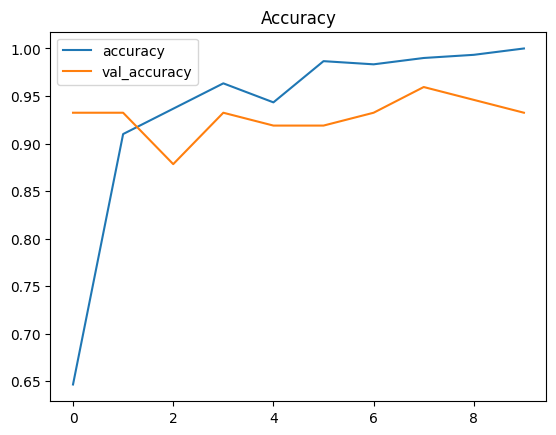

In [39]:

# visualization of accuracy and val_accuracy:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


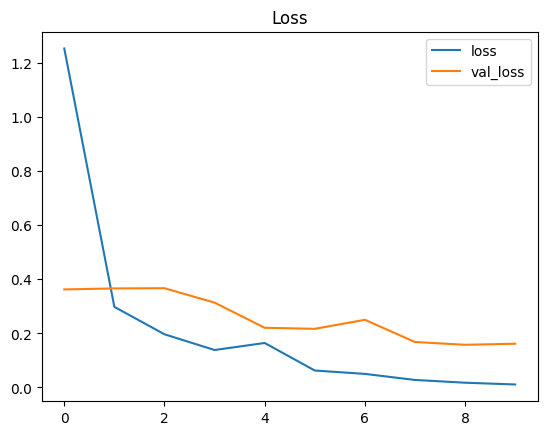

In [40]:

# visualization of loss and val_loss:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()


In [41]:

# predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


In [42]:

# import libraries for evaluation:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [43]:

# accuracy:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'--> Accuracy on the test set: {acc * 100:.2f}%')


--> Accuracy on the test set: 98.94%


In [44]:

class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)


              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        13
        boat       1.00      1.00      1.00        13
         bus       1.00      0.91      0.95        11
         car       1.00      1.00      1.00         8
       cycle       1.00      1.00      1.00        10
  helicopter       1.00      1.00      1.00        11
       plane       1.00      1.00      1.00        14
      scooty       1.00      1.00      1.00         9
       truck       0.83      1.00      0.91         5

    accuracy                           0.99        94
   macro avg       0.98      0.99      0.98        94
weighted avg       0.99      0.99      0.99        94



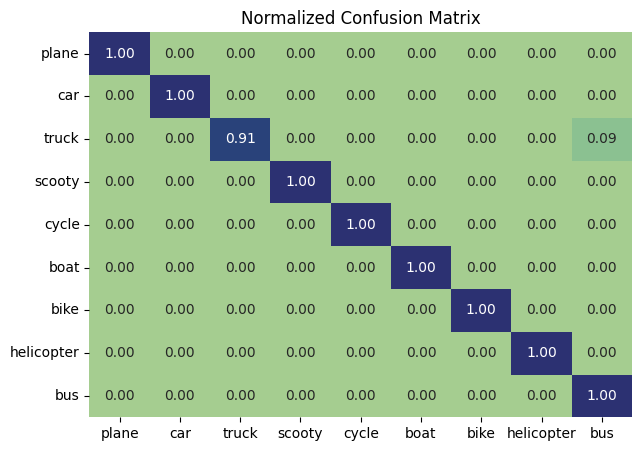

In [48]:

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (7,5))
sns.heatmap(cf_matrix,annot=True,xticklabels=set(y_test),yticklabels=set(y_test),cmap="crest",cbar=False,fmt=".2f")
plt.title('Normalized Confusion Matrix', fontsize = 12)
plt.xticks()
plt.yticks()
plt.show()


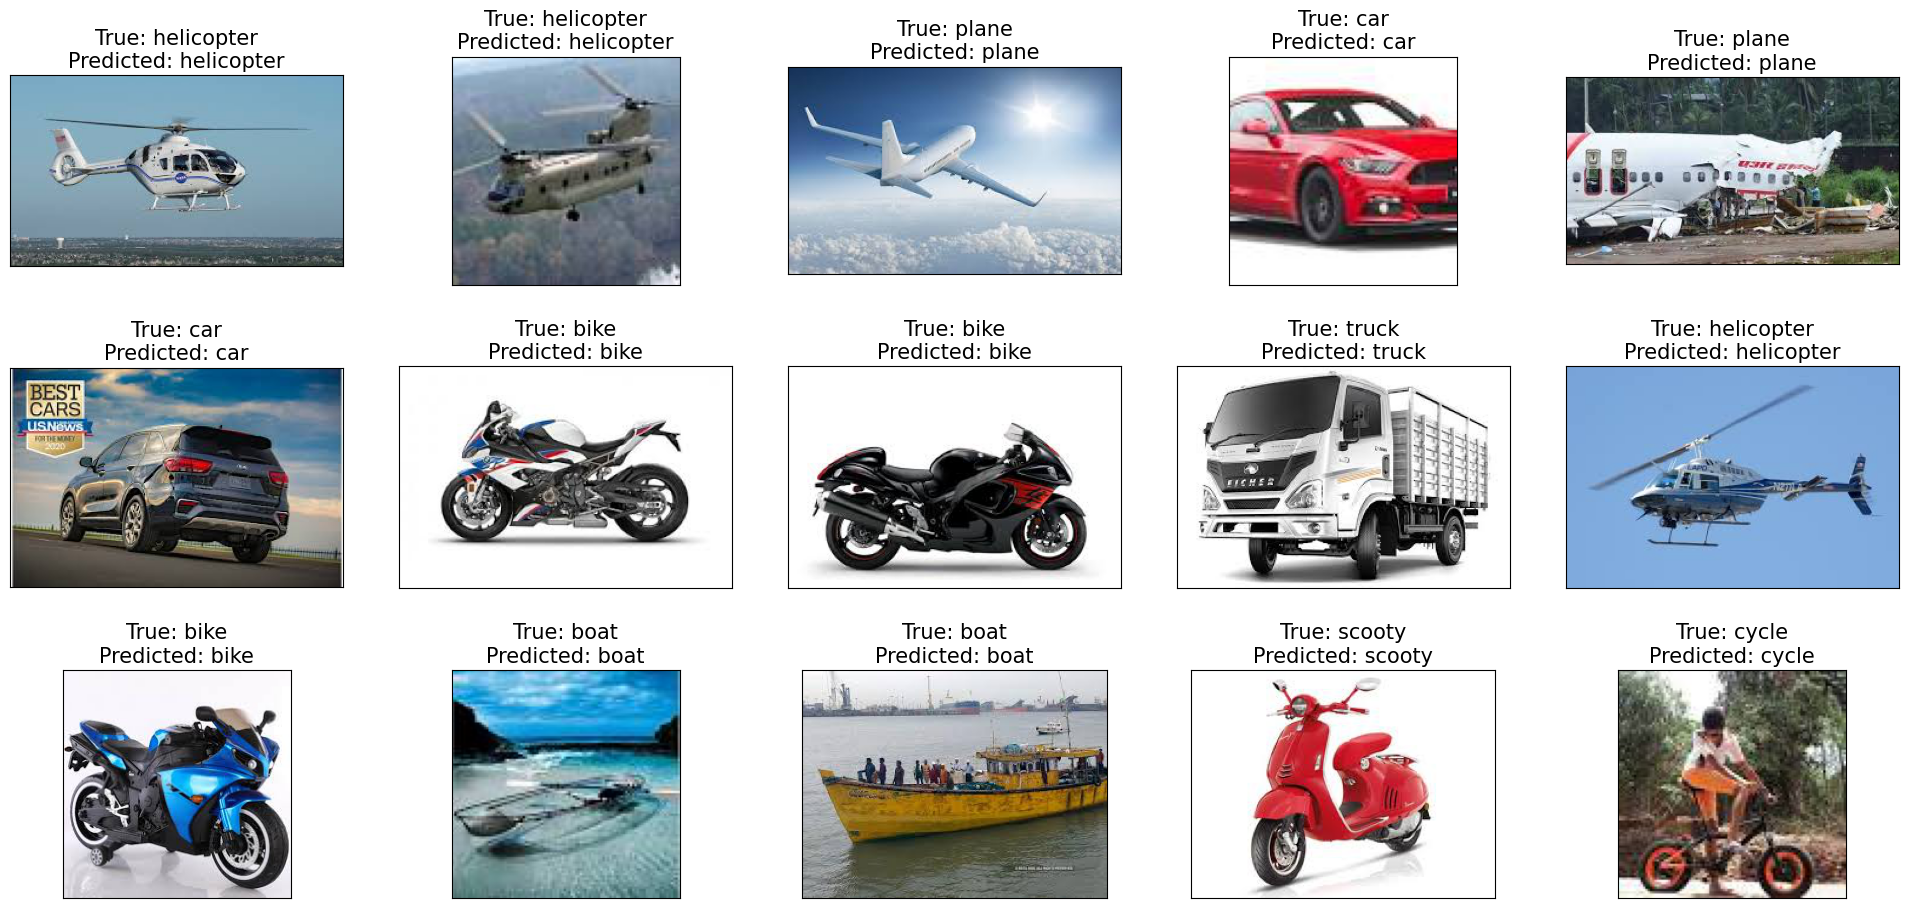

In [49]:

# display picture of the dataset with their labels/predictions:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    color = 'black'
    if test_df.Label.iloc[i].split('_')[0] != pred[i].split('_')[0]:
        # in case of a false prediction --> red font 
        color = 'r'
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15,color=color)
plt.tight_layout(pad=4)
plt.show()
